# Early Stage Diabetes Risk Prediction

add introduction here!!!

## Problem Statement


From dataset, trying to predict whether a patient has diabetes or not.

## The Dataset
https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("diabetes_prediction_dataset.csv")
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


There are 100,000 entries in this dataset. On first appearances, there are no null values.

## Data pre-processing

Most of the features are numerical. Only gender and smoking_history are categorical and will later need to be turned numerical.

Hypertension, heart_disease and diabetes are all binary features.

In [4]:
df["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

Around 36% of entries are missing smoking_history info. This would be quite a lot of data to drop, so I will not drop them.

Instead, I will use Mode Category Imputation based on gender and age.

In [5]:
# This function takes all entries within an age range as a parameter
# It returns the most common value for 'smoking_history' that is not 'No Info'
def get_mode_smoking_history_from_group(group):
    value_counts = group.value_counts()    
    most_common = value_counts.index[0] if value_counts.index[0] != "No Info" else value_counts.index[1]    
    return most_common

# Group all entries into age_group bins of width 5 (years). 
# Replace all smoking_history values of 'No Info' with the most common value in the respective age group.
df['age_group'] = pd.cut(df['age'], bins=np.arange(0, df["age"].max(), 5), right=False)
df['smoking_history_of_age_group'] = df.groupby('age_group')['smoking_history'].transform(lambda x: get_mode_smoking_history_from_group(x))
df.loc[df['smoking_history'] == 'No Info', 'smoking_history'] = df['smoking_history_of_age_group']

# Check that there are no more counts for 'No Info'
df["smoking_history"].value_counts()

/var/folders/nl/l_thjhtd7s13pv8s4s13w7nh0000gn/T/ipykernel_31820/969091834.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['smoking_history_of_age_group'] = df.groupby('age_group')['smoking_history'].transform(lambda x: get_mode_smoking_history_from_group(x))


smoking_history
never          68123
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

In [6]:
df["gender"].value_counts()

gender
Female    58552
Male      41430
Other        18
Name: count, dtype: int64

Out of 100,000 entries, there are only 18 entries with the gender 'Other'. 18 data points is not enough to make assumptions on the greater population, so I will drop these entries.

In [7]:
df = df[df['gender'] != 'Other']
df['gender'].describe()

count      99982
unique         2
top       Female
freq       58552
Name: gender, dtype: object

## Exploratory Analysis

I want to first look at the categorical features (gender and smoking_history) to see if there is correlation between them and being positive for diabetes.

Text(0.5, 1.0, 'Graph showing diabetes rate by gender')

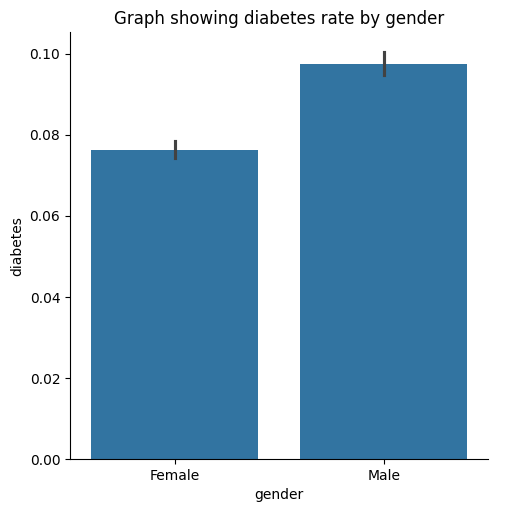

In [8]:
sns.catplot(
    data=df, x="gender", y="diabetes",
    kind="bar"
)
plt.title("Graph showing diabetes rate by gender")

From the graph, it seems that males have higher rates of diabetes. It also shows that in our dataset, there are no people recorded as having an 'other' gender who have diabetes.

Text(0.5, 1.0, 'Graph showing diabetes rate by smoking history')

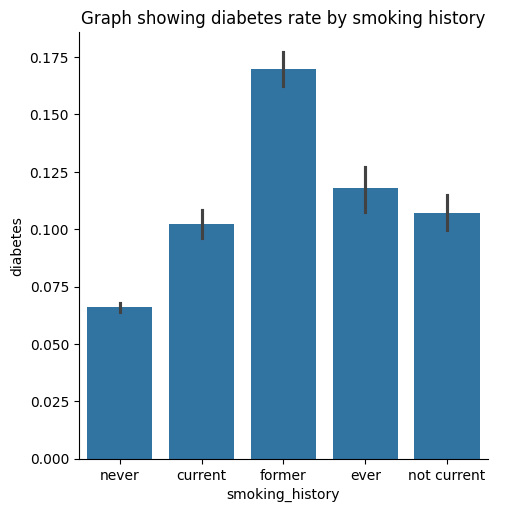

In [9]:
sns.catplot(
    data=df, x="smoking_history", y="diabetes",
    kind="bar"
)
plt.title("Graph showing diabetes rate by smoking history")

This graph seems to show that there is a correlation between smoking history and rates of diabetes. Those who have never smoked have lowest rates of diabetes where was those who were former smokers have highest rates of diabetes.

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'hypertension'}>,
        <Axes: title={'center': 'heart_disease'}>],
       [<Axes: title={'center': 'bmi'}>,
        <Axes: title={'center': 'HbA1c_level'}>,
        <Axes: title={'center': 'blood_glucose_level'}>],
       [<Axes: title={'center': 'diabetes'}>, <Axes: >, <Axes: >]],
      dtype=object)

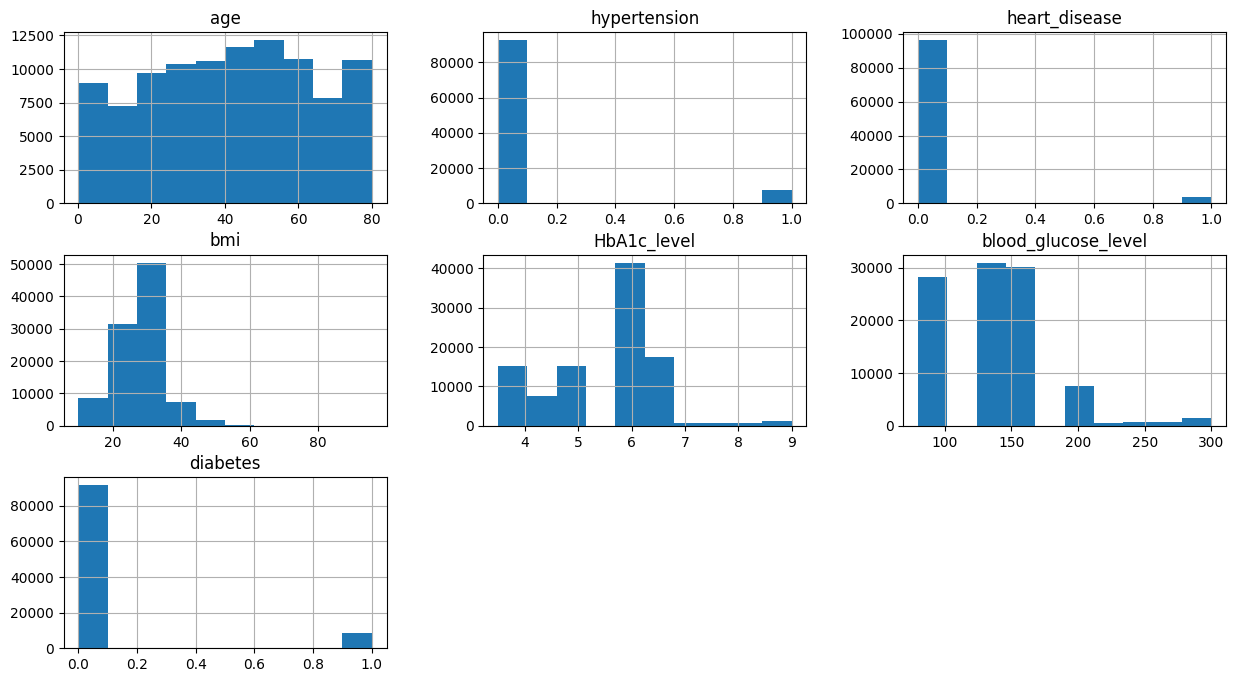

In [10]:
df.hist(figsize=(15,8))

Next, I'm going to look at the numerical features and see their correlations with diabetes rates.

<Axes: >

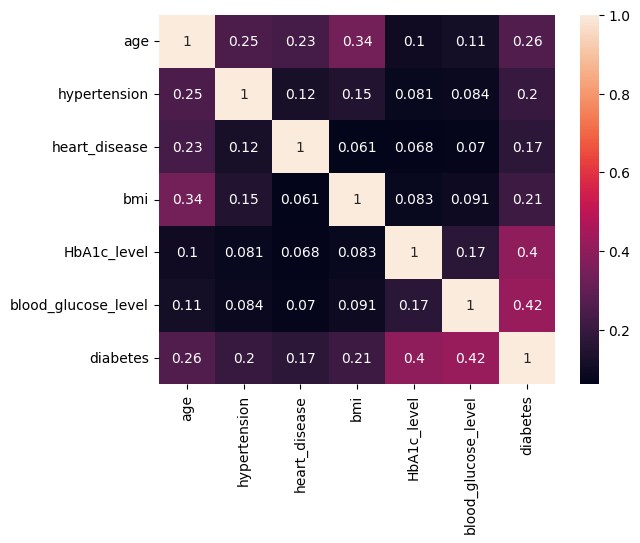

In [11]:
# Create a correlation matrix between all features
correlation = df.corr(numeric_only=True)
sns.heatmap(correlation, annot=True)

It seems that there are positive correlations between diabetes and all the other numerical features. The strongest correlations are with blood_glucose_level and HbA1c_level. 

There are no correlations between the other features that are high enough to make me suspect multicollinearity.

I could visualise these correlations using box plots (as I do for blood_glucose_level below), but the correlation heatmap is enough for me to determine that I will include all of the numerical features in the prediction model.

Text(0.5, 1.0, 'Box plots showing the distribution of Blood Glucose Levels for people wiht and without diabetes')

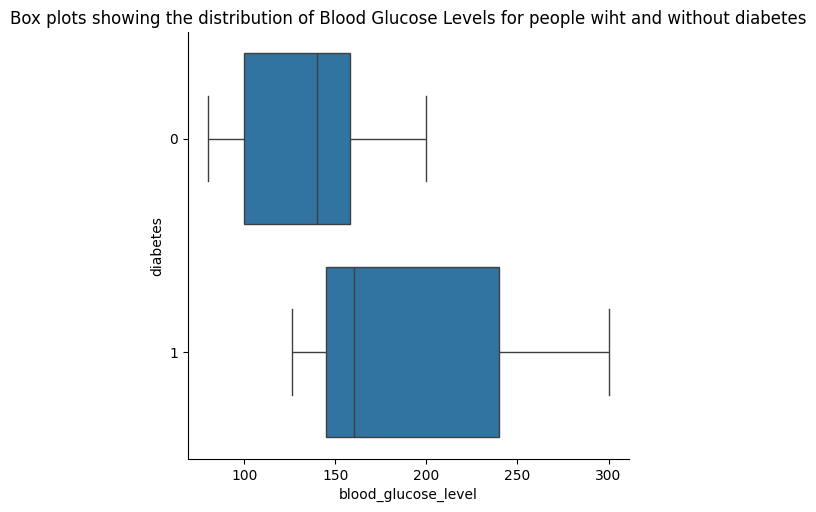

In [24]:
df['diabetes'] = df['diabetes'].astype('category')
sns.catplot(data=df, x="blood_glucose_level", y="diabetes", kind="box")
plt.title("Box plots showing the distribution of Blood Glucose Levels for people wiht and without diabetes")

## Categorical Feature Encoding

Since there are now 2 values for gender, I will turn the feature into a binary feature.

In [13]:
df = df.join(pd.get_dummies(df.gender, prefix="gender", dtype=int))

In [14]:
## Encoding Categorical Variables:
df = df.join(pd.get_dummies(df.smoking_history, prefix="smoking_history", dtype=int))
df.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes,age_group,smoking_history_of_age_group,gender_Female,gender_Male,smoking_history_current,smoking_history_ever,smoking_history_former,smoking_history_never,smoking_history_not current
0,Female,80.0,0,1,never,25.19,6.6,140,0,NaN,NaN,1,0,0,0,0,1,0
1,Female,54.0,0,0,never,27.32,6.6,80,0,"[50.0, 55.0)",never,1,0,0,0,0,1,0
2,Male,28.0,0,0,never,27.32,5.7,158,0,"[25.0, 30.0)",never,0,1,0,0,0,1,0
3,Female,36.0,0,0,current,23.45,5.0,155,0,"[35.0, 40.0)",never,1,0,1,0,0,0,0
4,Male,76.0,1,1,current,20.14,4.8,155,0,NaN,NaN,0,1,1,0,0,0,0


In [15]:
## Sampling